In [ ]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [ ]:
#데이터 불러오기
fashion=pd.read_csv('/content/drive/MyDrive/DSL/fashion-mnist.csv')
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


In [ ]:
fashion.shape

(60000, 785)

- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [ ]:
# train, test 데이터셋이 각각 50000, 10000개

train_set = fashion.loc[:49999,:]
test_set = fashion.loc[50000:59999,:]

print(train_set.shape)
print(test_set.shape)

(50000, 785)
(10000, 785)


In [ ]:
# train, test 데이터셋을 image와 label로 나누기

X_train = train_set.iloc[:, 1:]
y_train = train_set['label']

X_test = test_set.iloc[:, 1:]
y_test = test_set['label']

for i in [X_train, y_train, X_test, y_test]:
    print(i.shape)

(50000, 784)
(50000,)
(10000, 784)
(10000,)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


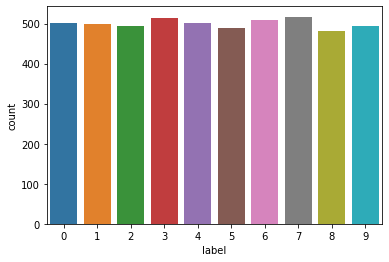

In [ ]:
# train dataset으로 5000개만 사용

X_train=X_train.loc[:4999,:] # 앞에서부터 5000장 뽑음
y_train=y_train[:5000]
sns.countplot(y_train) #y라벨이 균등하게 분포하는지 확인
plt.show() #y라벨이 균등하게 분포하는 편이라 할 수 있음

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


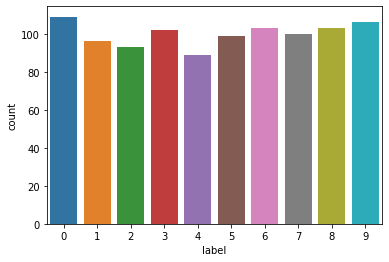

In [ ]:
# test dataset으로 1000개만 사용 (랜덤한 기준으로, 균등한 분포를 보이는 4000~4999번째까지로 함)

X_test=X_test.loc[55000:55999,:]
y_test=y_test[4000:5000]
sns.countplot(y_test)
plt.show() #y라벨값 분포가 대체로 균등한 편이라 할 수 있음

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5000, 784) (5000,) (1000, 784) (1000,)


- 어떻게 생긴 데이터셋인지 확인해보기

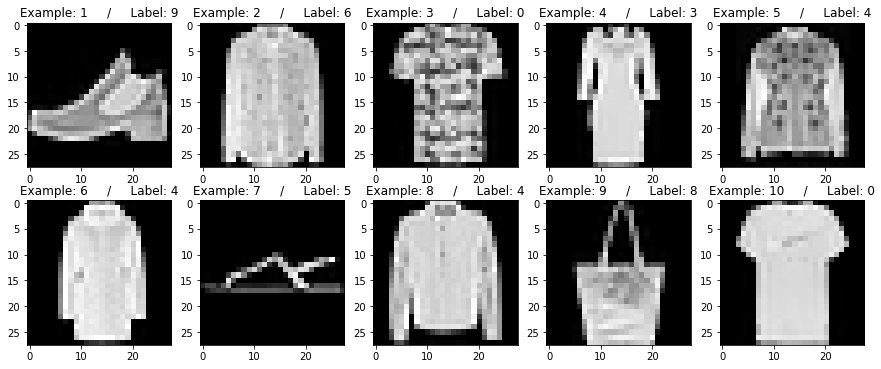

In [ ]:
plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  label = y_train.loc[i]
  image = X_train.loc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

# PCA를 활용해 성능 높여보기


In [ ]:
from sklearn.decomposition import PCA

pca=PCA(n_components=784) #784차원의 잠재변수
X_train_PCA=pca.fit_transform(X_train) #X_train에는 original 변수들이, X_Train_PCA에는 잠재변수들이 들어가있다
X_train_PCA.shape

(5000, 784)

## (Q2) 합리적인 잠재변수 개수 설정하기

- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [ ]:
pca.explained_variance_ratio_[:10]

array([0.28911501, 0.17643681, 0.06015456, 0.05078552, 0.03915467,
       0.03488659, 0.0228115 , 0.01931853, 0.0139818 , 0.01294042])

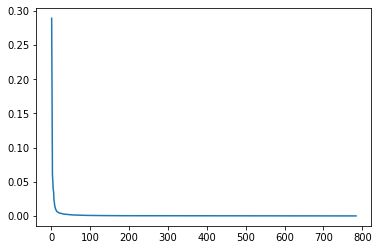

In [ ]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.show()

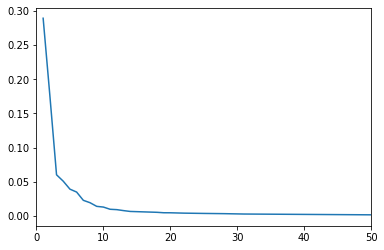

In [ ]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.xlim(0,50)
plt.show()

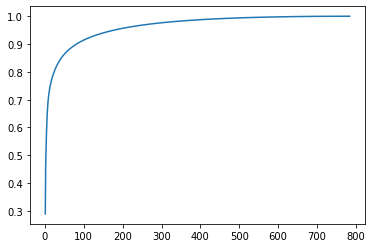

In [ ]:
cumulative = []
temp = 0
for i in range(0, 784):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)

plt.plot(range(1,785),cumulative)
plt.show()

In [ ]:
for i in [10,20,50,100,784]:
  explained=np.sum(pca.explained_variance_ratio_[:i])
  print(i,'개의 잠재변수가 설명하는 분산은 전체 데이터의 {:.2f}%'.format(explained*100))

10 개의 잠재변수가 설명하는 분산은 전체 데이터의 71.96%
20 개의 잠재변수가 설명하는 분산은 전체 데이터의 78.51%
50 개의 잠재변수가 설명하는 분산은 전체 데이터의 86.36%
100 개의 잠재변수가 설명하는 분산은 전체 데이터의 91.44%
784 개의 잠재변수가 설명하는 분산은 전체 데이터의 100.00%


In [ ]:
cumulative=np.array(cumulative)
np.where(cumulative>0.8)[0][0] #23개를 사용하면 분산의 80%를 설명 -> 23차원으로 축소하겠다

23

## (Q3) 학습속도, 성능의 향상을 보이는지 확인

- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


In [ ]:
#pca를 통한 특징 추출 과정에서는 y라벨을 사용하지X(unsupervised)
#성능 확인 과정에서 y라벨이 사용됨
pca=PCA(n_components=23)
X_train_PCA=pca.fit_transform(X_train) #train은 fit + transform
X_test_PCA=pca.transform(X_test)       #test는 transform
print('Original space:',X_train.shape)
print('After PCA:',X_train_PCA.shape)

Original space: (5000, 784)
After PCA: (5000, 23)


### Logistic regression

In [ ]:
#차원축소 이전(origianl 공간 784차원)
start=time.time()
logistic_original=LogisticRegression(max_iter=1000) #warning 메시지가 나와서 max_iter 지정해줌
logistic_original.fit(X_train,y_train)  #train set만 고려
print('train accuracy:',accuracy_score(y_train, logistic_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, logistic_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.087
57.3919sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#차원축소 이후(23차원)
start=time.time()
logistic_pca=LogisticRegression(max_iter=1000) 
logistic_pca.fit(X_train_PCA,y_train)
print('train accuracy:',accuracy_score(y_train, logistic_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, logistic_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.8198
test accuracy: 0.088
12.4662sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- PCA 이후 학습 속도 개선됨. 
- PCA 이전의 train accuracy가 오히려 더 높은 수치를 보이지만, test accuracy는 미세하게 조금더 높다. PCA 이전 고차원 공간에서 학습데이터가 과적합되어 나타나는 현상이라 할 수 있다.
- 더 빠른 속도로 비슷한 성능을 보인다.

### Random Forest

In [ ]:
#차원축소 이전(784차원)
start=time.time()
rf_original=RandomForestClassifier()
rf_original.fit(X_train,y_train)
print('train accuracy:',accuracy_score(y_train, rf_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, rf_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.079
5.9810sec


In [ ]:
#차원축소 이후(23차원)
start=time.time()
rf_pca=RandomForestClassifier()
rf_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, rf_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, rf_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.09
2.3316sec


- 차원축소 이후, 학습속도는 크게 감소하지는 않음 (약 3초)병렬적 학습이기에, 애초에 학습속도가 빠른 편임
- 성능은 PCA 이후가 미세하게 높음

### XGBoost

In [ ]:
#차원축소 이전(784차원)
from xgboost import XGBClassifier
start=time.time()
xgboost_original = XGBClassifier()
xgboost_original.fit(X_train, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, xgboost_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.9602
test accuracy: 0.084
141.3647sec


In [ ]:
#차원축소 이후(23차원)
start=time.time()
xgboost_pca = XGBClassifier()
xgboost_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, xgboost_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.905
test accuracy: 0.089
9.6380sec


- 차원축소 이후 학습속도가 급격하게 감소함 (2분 30초에서 9초로 감소)
- PCA 이후, 성능 또한 미세하게 좋아짐.
- 훨씬 더 빠른 속도로 조금 더 좋은 성능을 보임!!

# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

## PCA

In [ ]:
start=time.time()
pca=PCA(n_components=2)
X_train_PCA=pca.fit_transform(X_train) 
print(f'{time.time()-start:.4f}sec')

0.6861sec


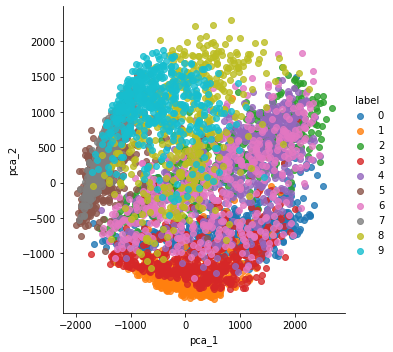

In [ ]:
X_train_pca=pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca=pd.concat((X_train_pca, y_train), axis=1) 
X_train_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x='pca_1',y='pca_2',data=X_train_pca,hue='label',fit_reg=False)
plt.show()

## MDS

In [ ]:
#시간 엄청 오래 걸림
from sklearn.manifold import MDS
start=time.time()
mds = MDS(n_components=2, random_state=42) #random_state 없애도 됨
X_train_mds = mds.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

916.9752sec


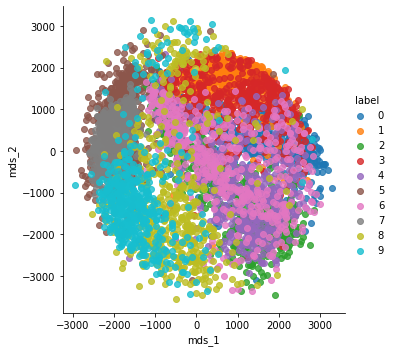

In [ ]:
X_train_mds=pd.DataFrame(X_train_mds).loc[:,0:1]
X_train_mds=pd.concat((X_train_mds, y_train), axis=1) 
X_train_mds.columns=['mds_1', 'mds_2', 'label']
X_train_mds

sns.lmplot(x='mds_1',y='mds_2',data=X_train_mds,hue='label',fit_reg=False)
plt.show()

## LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start=time.time()
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train) #차원축소 과정에 y라벨값을 입력해줌
print(f'{time.time()-start:.4f}sec')

3.1464sec


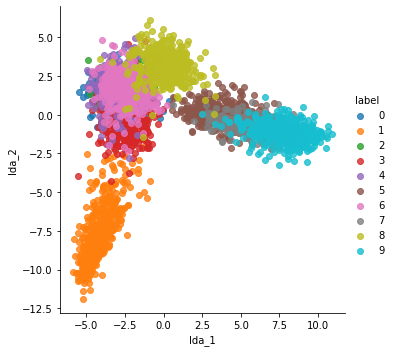

In [ ]:
X_train_lda=pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda=pd.concat((X_train_lda, y_train), axis=1) 
X_train_lda.columns=['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x='lda_1',y='lda_2',data=X_train_lda,hue='label',fit_reg=False)
plt.show()

## KPCA

In [ ]:
from sklearn.decomposition import KernelPCA
start=time.time()
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True) #방사형 커널 사용
X_train_rbf_pca=rbf_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

13.6539sec


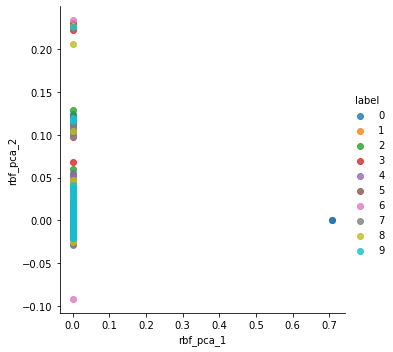

In [ ]:
X_train_rbf_pca=pd.DataFrame(X_train_rbf_pca).loc[:,0:1]
X_train_rbf_pca=pd.concat((X_train_rbf_pca, y_train), axis=1) 
X_train_rbf_pca.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca,hue='label',fit_reg=False)
plt.show()

In [ ]:
start=time.time()
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True) #시그모이드 커널 사용
X_train_sig_pca=sig_pca.fit_transform(X_train)
#X_test_rbf_pca=sig_pca.fit_transform(X_test)
print(f'{time.time()-start:.4f}sec')

11.3533sec


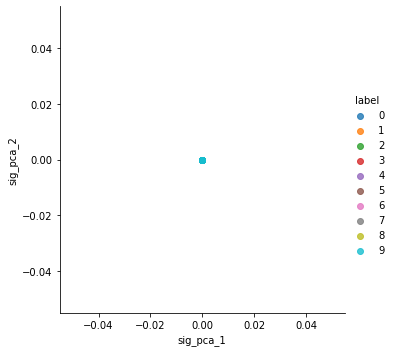

In [ ]:
X_train_sig_pca=pd.DataFrame(X_train_sig_pca).loc[:,0:1]
X_train_sig_pca=pd.concat((X_train_sig_pca, y_train), axis=1) 
X_train_sig_pca.columns=['sig_pca_1', 'sig_pca_2', 'label']

sns.lmplot(x='sig_pca_1',y='sig_pca_2',data=X_train_sig_pca,hue='label',fit_reg=False)
plt.show()

In [ ]:
from sklearn.decomposition import KernelPCA
start=time.time()
lin_pca = KernelPCA(n_components = 2, kernel="linear", gamma=0.1, fit_inverse_transform=True)
X_train_lin_pca=lin_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

9.9083sec


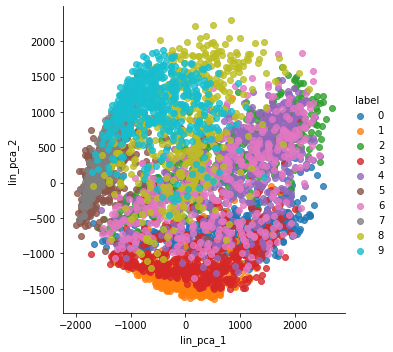

In [ ]:
X_train_lin_pca=pd.DataFrame(X_train_lin_pca).loc[:,0:1]
X_train_lin_pca=pd.concat((X_train_lin_pca, y_train), axis=1) 
X_train_lin_pca.columns=['lin_pca_1', 'lin_pca_2', 'label']

sns.lmplot(x='lin_pca_1',y='lin_pca_2',data=X_train_lin_pca,hue='label',fit_reg=False)
plt.show()

## ISOMAP

In [ ]:
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=5,n_components=2,n_jobs=4) #neighbors의 수 조정 가능        
X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

19.0903sec


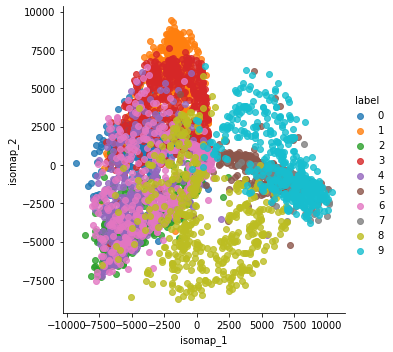

In [ ]:
X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

In [ ]:
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=10,n_components=2,n_jobs=4) #neighbors의 수 조정 가능        
X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

27.6390sec


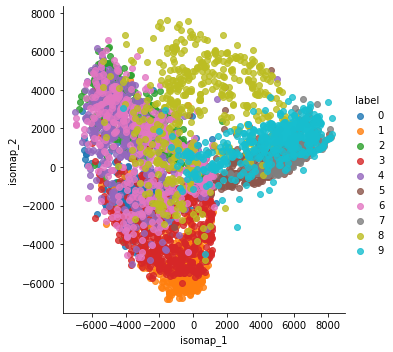

In [ ]:
X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

In [ ]:
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=20,n_components=2,n_jobs=4) #neighbors의 수 조정 가능        
X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

34.5070sec


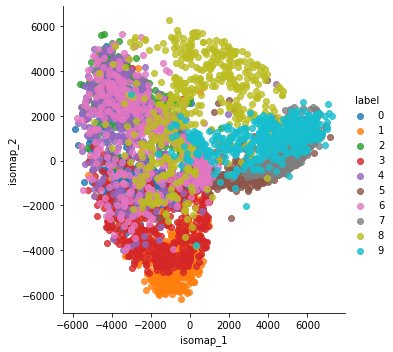

In [ ]:
X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

## LLE

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding
start=time.time()
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_train_lle = lle.fit_transform(X_train)
#X_test_lle=lle.transform(X_test)
print(f'{time.time()-start:.4f}sec')

2.5072sec


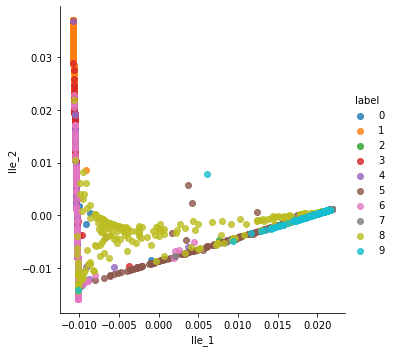

In [ ]:
X_train_lle=pd.DataFrame(X_train_lle).loc[:,0:1]
X_train_lle=pd.concat((X_train_lle, y_train), axis=1) 
X_train_lle.columns=['lle_1', 'lle_2', 'label']
X_train_lle

sns.lmplot(x='lle_1',y='lle_2',data=X_train_lle,hue='label',fit_reg=False)
plt.show()

## t-SNE

In [ ]:
from sklearn.manifold import TSNE
start=time.time()
tsne = TSNE(n_components=2, random_state=42) 
X_train_tsne = tsne.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


61.9159sec


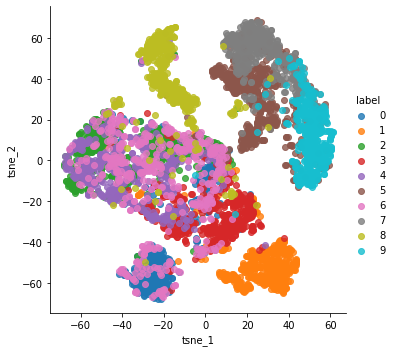

In [ ]:
X_train_tsne=pd.DataFrame(X_train_tsne).loc[:,0:1]
X_train_tsne=pd.concat((X_train_tsne, y_train), axis=1) 
X_train_tsne.columns=['tsne_1', 'tsne_2', 'label']
X_train_tsne

sns.lmplot(x='tsne_1',y='tsne_2',data=X_train_tsne,hue='label',fit_reg=False)
plt.show() 

## 시각화 결과 분석

### (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

- 시도해본 차원축소 방법 중, Fashion MNIST 데이터셋을 완벽하게 잘 시각화 한 방법은 찾지 못했지만, 비교적 가장 잘 시각화한 방법은 세 가지; LDA, n_neighbors=20인 ISOMAP, 그리고 t-SNE라 할 수 있다.
- 가장 잘 시각화한 것의 기준을, 같은 특징을 나타내는 데이터의 class별로 잘 묶여있는지, 서로 다른 특징을 나타내는 데이터의 class들은 시각적으로 서로 명확하게 구별되는지로 판단해보자. 이를 기준으로 두었을 때, LDA 방법으로 진행한 2차원 시각화가 가장 뚜렷하게 between-class distance가 최대화, within-class distance가 최소화되어 상대적으로 뚜렷하게 시각화 된 결과를 보이는 것을 알 수 있다. (t-SNE, ISOMAP (n_neighbors=20)이 그 뒤를 잇는다) 다른 분류 방법들은 시각화가 뭉개져 나타나 구별이 뚜렷하지 않다.

### (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

- 저차원에서 제대로 분류가 잘 되지 않는 라벨은 크기가 대체로 큰 라벨 (6~9)인 것 같다. PCA, MDS, KPCA, Isomap, LLE 등 대부분의 2차원 시각화 결과에서 모여지 있지 않고, 가장 넓게 분포되어 있는 것을 볼 수 있기에 이렇게 추측하였다.
- 아무래도, 고차원에서의 특징과 저차원에서의 특징 비교적 큰 차이를 보이기에, 저차원으로 차원축소되었을 때, 데이터의 정보가 잘 보존되지 않았을 확률이 존재한다.

수고하셨습니다~